Данный ноутбук представляет собой ноутбук работы с данными NIH-Chest-X-rays.

Прежде чем запускать данный ноутбук, Вам необходимо выполнить шаг (1) из Preprocessing.ipynb.

# Библиотеки

In [1]:
import pandas as pd
import numpy as np 
import keras_cv
import tensorflow as tf
import os
from glob import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from itertools import chain
from keras.applications.densenet import DenseNet121
from keras import Model
from keras import layers
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from keras.models import *
from keras.layers import *
from tensorflow.keras.layers import GlobalAveragePooling2D, Multiply
from keras.optimizers import *
from tensorflow.keras import backend as keras
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam 
%matplotlib inline
os.environ["KERAS_BACKEND"] = "tensorflow"

2024-08-27 17:24:42.292790: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-27 17:24:43.067245: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Параметры

In [2]:
DATA_FOLDER = 'Data Kaggle' # Папка в которой хранятся данные   
INDICES_FILE = 'Data_Entry_2017_v2020_edit.csv' # Название файла, который содержит разметку

IMG_SIZE = 224 # Размер изображения для модели
BATCH_SIZE = 32 # Размер батча
LEARNING_RATE = 0.0001 # Скорость обучения
EPOCHS = 100 # Максимальное количество эпох

SEED = 42 # Номер сида

# Функции

'''
Reference
https://www.kaggle.com/xhlulu/ranzcr-efficientnet-tpu-training
'''

In [3]:
def build_decoder(with_labels=True, target_size=(IMG_SIZE, IMG_SIZE)):
    """
    Создает декодер для изображений.

    Параметры:
    with_labels (bool): Если True, декодер будет возвращать изображения вместе с метками. По умолчанию True.
    target_size (tuple): Размер, до которого будут изменены изображения. По умолчанию (IMG_SIZE, IMG_SIZE).

    Возвращает:
    function: Функция декодирования изображений. Если with_labels=True, возвращает функцию, которая принимает путь к изображению и метку, и возвращает декодированное изображение и метку. Если with_labels=False, возвращает функцию, которая принимает только путь к изображению и возвращает декодированное изображение.
    """
    def decode(path):
        """
        Декодирует изображение из файла.

        Параметры:
        path (str): Путь к файлу изображения.

        Возвращает:
        tf.Tensor: Декодированное изображение.
        """
        file_bytes = tf.io.read_file(path) 
        img = tf.image.decode_png(file_bytes, channels=1) 
        img = tf.cast(img, tf.float32) / 255.0 
        img = tf.image.resize(img, target_size) 
        img = tf.repeat(img, 3, axis=-1)
        return img
    
    def decode_with_labels(path, label):
        """
        Декодирует изображение из файла и возвращает его вместе с меткой.

        Параметры:
        path (str): Путь к файлу изображения.
        label (any): Метка, связанная с изображением.

        Возвращает:
        tuple: Декодированное изображение и метка.
        """
        return decode(path), label
    
    return decode_with_labels if with_labels else decode

In [4]:
def build_augmenter(with_labels=True):
    """
    Создает аугментатор для изображений.

    Параметры:
    with_labels (bool): Если True, аугментатор будет возвращать изображения вместе с метками. По умолчанию True.

    Возвращает:
    function: Функция аугментации изображений. Если with_labels=True, возвращает функцию, которая принимает изображение и метку, и возвращает аугментированное изображение и метку. Если with_labels=False, возвращает функцию, которая принимает только изображение и возвращает аугментированное изображение.
    """
    augmenter = keras_cv.layers.Augmenter(
        [
            keras_cv.layers.RandomFlip(mode="horizontal_and_vertical"),
            keras_cv.layers.RandomRotation(factor=(-0.04, 0.04), fill_mode="constant", fill_value=0),
        ],
    )
    rotation = keras_cv.layers.RandomRotation(factor=(0.25, 0.25), fill_mode="constant", fill_value=0)

    def augment(inputs):
        """
        Аугментирует входные данные.

        Параметры:
        inputs (dict): Словарь с ключами 'images' и 'labels', где 'images' - это изображения, а 'labels' - метки.

        Возвращает:
        tuple: Аугментированные изображения и метки.
        """
        outputs = inputs
        outputs = augmenter(outputs)
        if tf.random.uniform([]) < 0.5:
            outputs['images'] = rotation(outputs['images'])
        return outputs['images'], outputs['labels']

    def augment_with_labels(img, label):
        """
        Аугментирует изображение и возвращает его вместе с меткой.

        Параметры:
        img (tf.Tensor): Изображение.
        label (any): Метка, связанная с изображением.

        Возвращает:
        tuple: Аугментированное изображение и метка.
        """
        return augment({"images": img, "labels": label})

    return augment_with_labels if with_labels else augment

In [5]:
def build_dataset(paths, labels=None, batch_size=32, decode_fn=None, augment_fn=None, augment=True, repeat=True):
    """
    Создает набор данных для обучения модели.

    Параметры:
    paths (list): Список путей к изображениям.
    labels (list, optional): Список меток, соответствующих изображениям. По умолчанию None.
    batch_size (int): Размер батча. По умолчанию 32.
    decode_fn (function, optional): Функция декодирования изображений. По умолчанию None.
    augment_fn (function, optional): Функция аугментации изображений. По умолчанию None.
    augment (bool): Если True, изображения будут аугментированы. По умолчанию True.
    repeat (bool): Если True, набор данных будет повторяться бесконечно. По умолчанию True.

    Возвращает:
    tf.data.Dataset: Набор данных, готовый для обучения модели.
    """
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    dset = tf.data.Dataset.from_tensor_slices(slices)
    dset = dset.map(decode_fn, num_parallel_calls=AUTO)
    dset = dset.map(augment_fn, num_parallel_calls=AUTO) if augment else dset
    dset = dset.repeat() if repeat else dset
    dset = dset.batch(batch_size).prefetch(AUTO)
    return dset

In [6]:
def plot_loss_metrics(history, metric1, metric2, label1, label2):
    """
    Строит графики метрик обучения и валидации.

    Параметры:
    history (tf.keras.callbacks.History): Объект истории, содержащий данные о метриках обучения и валидации.
    metric1 (str): Название первой метрики для построения графика.
    metric2 (str): Название второй метрики для построения графика.
    label1 (str): Метка для первой метрики.
    label2 (str): Метка для второй метрики.

    Возвращает:
    None
    """
    plt.figure(figsize=(12, 4))
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel(metric1, fontsize=14)
    plt.plot(history.history[metric1], label=f"Training {label1}", marker='o', markersize=6, linewidth=2)
    plt.plot(history.history[f"val_{metric1}"], label=f"Validation {label1}", marker='+', markersize=8, linewidth=2)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend(fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel(metric2, fontsize=14)
    plt.plot(history.history[metric2], label=f"Training {label2}", marker='o', markersize=6, linewidth=2)
    plt.plot(history.history[f"val_{metric2}"], label=f"Validation {label2}", marker='+', markersize=8, linewidth=2)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend(fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

In [7]:
def plot_roc_auc(model_name, valid_data, valid_labels, metadata):
    """
    Строит графики ROC-AUC для каждой категории и выводит AUC для каждой категории.

    Параметры:
    model_name (str): Имя файла модели, которую нужно загрузить.
    valid_data (numpy.ndarray): Данные для валидации.
    valid_labels (numpy.ndarray): Метки для валидации.
    metadata (pandas.DataFrame): Метаданные, содержащие названия категорий.

    Возвращает:
    None
    """
    tf.keras.backend.clear_session()

    model = tf.keras.models.load_model(model_name)
    pred = model.predict(valid_data, verbose=1)

    print('AUC для каждого класса')
    classes = metadata.columns[3:-1]
    scores = []
    for i, n in enumerate(classes):
        print(classes[i])
        print(i, roc_auc_score(valid_labels[:, i], pred[:, i]))
        print('----------------------------------------------')
        scores.append(roc_auc_score(valid_labels[:, i], pred[:, i]))

    fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
    for (idx, c_label) in enumerate(classes):
        fpr, tpr, thresholds = roc_curve(valid_labels[:, idx].astype(int), pred[:, idx])
        c_ax.plot(fpr, tpr, label='%s (AUC:%0.2f)' % (c_label, roc_auc_score(valid_labels[:, idx], pred[:, idx])))
    c_ax.legend(fontsize=12)
    c_ax.set_xlabel('False Positive Rate', fontsize=14)
    c_ax.set_ylabel('True Positive Rate', fontsize=14)
    c_ax.tick_params(axis='both', which='major', labelsize=12)
    fig.savefig(model_name[:-5] + 'png')
    plt.show()

# Подготовка данных

Для обучения и проверки модели, мы будем брать снимки пациентов от 18 лет и снимки с патологиями.

In [8]:
metadata = pd.read_csv(os.path.join(DATA_FOLDER, INDICES_FILE))
metadata = metadata[metadata['Patient Age'] >= 18]
file_system_scan = {os.path.basename(x): x for x in glob(os.path.join(DATA_FOLDER, '**', '**', '*.png'))}

metadata['path'] = metadata['Image Index'].map(file_system_scan.get)  
metadata = metadata[metadata['Finding Labels'] != 'No Finding']
print('Общее количество записей рентгеновских снимков:{}.'.format((metadata.shape[0])))  

Общее количество записей рентгеновских снимков:49501.


Посчитаем количество случаев для каждой патологии и сделаем бинарные метки.

In [9]:
metadata = metadata[['path', 'Image Index', 'Finding Labels']]

labels = np.unique(
    list(chain(*metadata['Finding Labels'].map(lambda x: x.split('|')).tolist())))
labels = [x for x in labels if len(x) > 0]

for c_label in labels:
    if len(c_label) > 1:
        metadata[c_label] = metadata['Finding Labels'].map(
            lambda finding: 1.0 if c_label in finding else 0)

labels_count = [(c_label, int(metadata[c_label].sum())) for c_label in labels]

print('Патологии ({}:{})'.format((len(labels)), (labels_count)))

Патологии (13:[('Atelectasis', 11203), ('Cardiomegaly', 2625), ('Consolidation', 4386), ('Edema', 2183), ('Effusion', 12858), ('Emphysema', 2410), ('Fibrosis', 1668), ('Hernia', 226), ('Infiltration', 18785), ('Nodule/Mass', 10857), ('Pleural_Thickening', 3270), ('Pneumonia', 1319), ('Pneumothorax', 4978)])


Удалим записи "мусорных" снимков.

In [10]:
with open("Bad png.txt", "r") as file:
    bad_images = file.read().splitlines()

metadata = metadata[~metadata['path'].map(os.path.basename).isin(bad_images)]

print('Общее количество записей рентгеновских снимков после удаления плохих изображений:{}.'.format((metadata.shape[0])))

Общее количество записей рентгеновских снимков после удаления плохих изображений:49114.


Мы будем делить данные на выборки таким образом, чтобы пациент был только в одной выборке и у него был только один снимок.

In [11]:
metadata['Patient Index'] = metadata['path'].apply(lambda x: x.split('/')[-1].split('_')[0])

patient_indices = metadata['Patient Index'].unique()

train_patient_indices, valid_patient_indices = train_test_split(patient_indices, test_size=0.2, random_state=SEED)

train_data = metadata[metadata['Patient Index'].isin(train_patient_indices)]
valid_data = metadata[metadata['Patient Index'].isin(valid_patient_indices)]

train_data = train_data.groupby('Patient Index').first().reset_index()
valid_data = valid_data.groupby('Patient Index').first().reset_index()

train_paths = train_data['path']
valid_paths = valid_data['path']
train_labels = train_data[train_data.columns[4:]].values
valid_labels = valid_data[valid_data.columns[4:]].values

print(train_paths.shape, valid_paths.shape)

(11039,) (2760,)


In [12]:
train_labels_count = [(c_label, int(train_data[c_label].sum())) for c_label in labels]
print('Train data labels count: {}'.format(train_labels_count))

valid_labels_count = [(c_label, int(valid_data[c_label].sum())) for c_label in labels]
print('Validation data labels count: {}'.format(valid_labels_count))

Train data labels count: [('Atelectasis', 2226), ('Cardiomegaly', 781), ('Consolidation', 513), ('Edema', 205), ('Effusion', 1581), ('Emphysema', 354), ('Fibrosis', 556), ('Hernia', 74), ('Infiltration', 4256), ('Nodule/Mass', 2779), ('Pleural_Thickening', 754), ('Pneumonia', 247), ('Pneumothorax', 400)]
Validation data labels count: [('Atelectasis', 562), ('Cardiomegaly', 186), ('Consolidation', 140), ('Edema', 51), ('Effusion', 397), ('Emphysema', 86), ('Fibrosis', 149), ('Hernia', 20), ('Infiltration', 1024), ('Nodule/Mass', 696), ('Pleural_Thickening', 183), ('Pneumonia', 56), ('Pneumothorax', 117)]


# Предсказание модели на обычных данных

In [13]:
name = 'NIH-Simple_model.keras'

decoder = build_decoder(with_labels=True, target_size=(IMG_SIZE, IMG_SIZE))
dtrain = build_dataset(train_paths, train_labels, batch_size=BATCH_SIZE, decode_fn=decoder, augment=False, repeat=True)
dvalid = build_dataset(valid_paths, valid_labels, batch_size=BATCH_SIZE, decode_fn=decoder, augment=False, repeat=False)

2024-08-27 17:24:52.194436: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-27 17:24:52.195370: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-27 17:24:52.195520: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

2024-08-27 17:24:52.778900: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-08-27 17:24:52.915904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


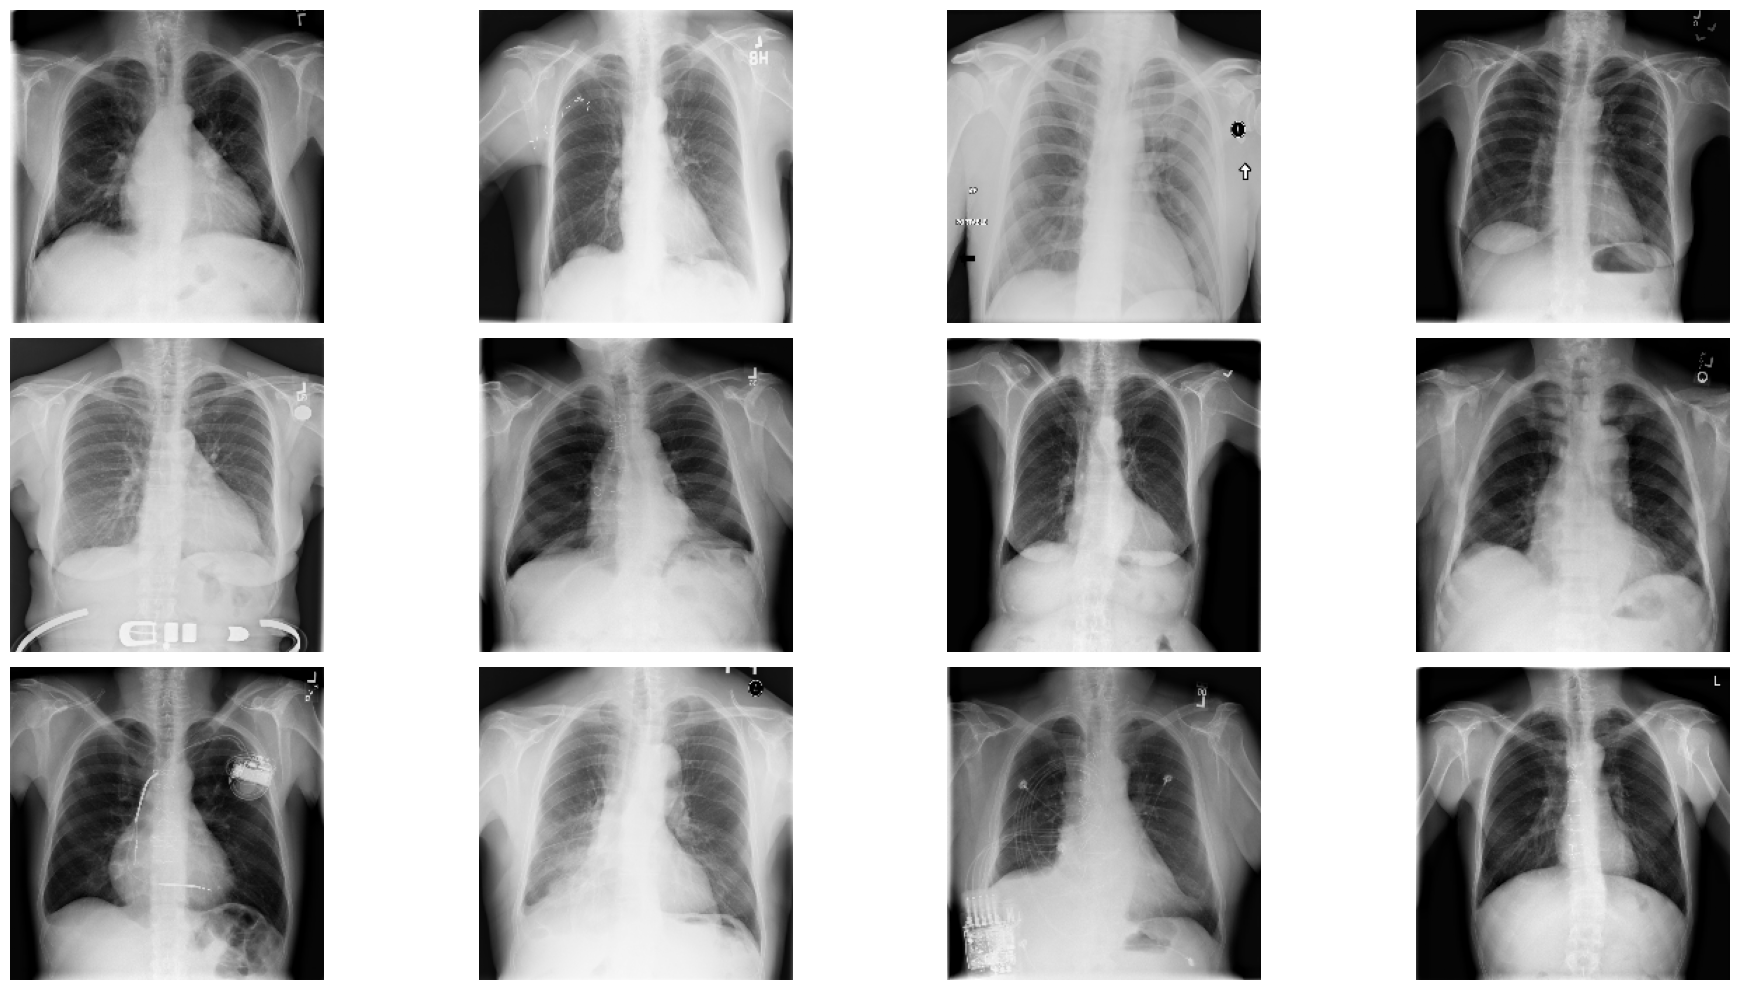

In [14]:
data, _ = dtrain.take(2)
images = data[0].numpy()
fig, axes = plt.subplots(3, 4, figsize=(20,10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [15]:
def build_model():
    base_model = DenseNet121(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
    
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(13, activation='sigmoid')(x)
    
    return Model(inputs=base_model.input, outputs=x)

model = build_model()
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.0)
model.compile(tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),loss=loss,metrics=[tf.keras.metrics.AUC(multi_label=True)])

In [16]:
rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5, verbose = 1, min_delta = 1e-4, min_lr = 1e-7, mode = 'min', cooldown=1)
ckp = ModelCheckpoint(name, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')
es = EarlyStopping(monitor = 'val_loss', min_delta = 1e-4, patience = 11, mode = 'min', restore_best_weights = True, verbose = 1)

callbacks_list = [rlr, ckp, es]

In [17]:
history = model.fit(dtrain,                      
                    validation_data=dvalid,                                       
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    steps_per_epoch=train_paths.shape[0]//BATCH_SIZE,
                    verbose=1)

Epoch 1/100


2024-08-27 17:25:48.716509: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
I0000 00:00:1724754348.843945    8403 service.cc:145] XLA service 0x7f9a0c002090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724754348.844175    8403 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-08-27 17:25:50.465651: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-27 17:25:55.394302: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1724754359.073845    8483 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_30763', 352 bytes spill stores, 352 bytes spill loads

I0000 00:00:1724754359.134905    8475 

344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - auc: 0.6050 - loss: 0.3537

2024-08-27 17:28:02.672502: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
I0000 00:00:1724754494.882019    8705 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3291', 520 bytes spill stores, 376 bytes spill loads




Epoch 1: val_loss improved from inf to 0.25799, saving model to NIH-Simple_model.keras
344/344 ━━━━━━━━━━━━━━━━━━━━ 192s 214ms/step - auc: 0.6052 - loss: 0.3534 - val_auc: 0.6971 - val_loss: 0.2580 - learning_rate: 1.0000e-04
Epoch 2/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - auc: 0.7507 - loss: 0.2433
Epoch 2: val_loss improved from 0.25799 to 0.25279, saving model to NIH-Simple_model.keras
344/344 ━━━━━━━━━━━━━━━━━━━━ 56s 162ms/step - auc: 0.7509 - loss: 0.2433 - val_auc: 0.7245 - val_loss: 0.2528 - learning_rate: 1.0000e-04
Epoch 3/100
  1/344 ━━━━━━━━━━━━━━━━━━━━ 45s 133ms/step - auc: 0.6329 - loss: 0.1957

2024-08-27 17:29:19.606960: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - auc: 0.8541 - loss: 0.2042
Epoch 3: val_loss did not improve from 0.25279
344/344 ━━━━━━━━━━━━━━━━━━━━ 56s 163ms/step - auc: 0.8542 - loss: 0.2042 - val_auc: 0.7151 - val_loss: 0.2943 - learning_rate: 1.0000e-04
Epoch 4/100
  2/344 ━━━━━━━━━━━━━━━━━━━━ 53s 157ms/step - auc: 0.7681 - loss: 0.1378

2024-08-27 17:30:15.842008: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - auc: 0.9292 - loss: 0.1535
Epoch 4: val_loss did not improve from 0.25279
344/344 ━━━━━━━━━━━━━━━━━━━━ 55s 159ms/step - auc: 0.9293 - loss: 0.1535 - val_auc: 0.7040 - val_loss: 0.3353 - learning_rate: 1.0000e-04
Epoch 5/100
  3/344 ━━━━━━━━━━━━━━━━━━━━ 49s 146ms/step - auc: 0.7770 - loss: 0.0954

2024-08-27 17:31:10.816927: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - auc: 0.9665 - loss: 0.1136
Epoch 5: val_loss did not improve from 0.25279
344/344 ━━━━━━━━━━━━━━━━━━━━ 54s 157ms/step - auc: 0.9666 - loss: 0.1136 - val_auc: 0.6841 - val_loss: 0.4067 - learning_rate: 1.0000e-04
Epoch 6/100
  4/344 ━━━━━━━━━━━━━━━━━━━━ 51s 151ms/step - auc: 0.8437 - loss: 0.0745

2024-08-27 17:32:04.914674: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - auc: 0.9782 - loss: 0.0886
Epoch 6: val_loss did not improve from 0.25279
344/344 ━━━━━━━━━━━━━━━━━━━━ 56s 163ms/step - auc: 0.9782 - loss: 0.0886 - val_auc: 0.6839 - val_loss: 0.3473 - learning_rate: 1.0000e-04
Epoch 7/100
  5/344 ━━━━━━━━━━━━━━━━━━━━ 56s 165ms/step - auc: 0.8362 - loss: 0.0614

2024-08-27 17:33:01.207767: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - auc: 0.9879 - loss: 0.0714
Epoch 7: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 7: val_loss did not improve from 0.25279
344/344 ━━━━━━━━━━━━━━━━━━━━ 58s 169ms/step - auc: 0.9879 - loss: 0.0713 - val_auc: 0.6541 - val_loss: 0.5087 - learning_rate: 1.0000e-04
Epoch 8/100
  6/344 ━━━━━━━━━━━━━━━━━━━━ 49s 147ms/step - auc: 0.9562 - loss: 0.0456

2024-08-27 17:33:59.223005: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - auc: 0.9836 - loss: 0.0857
Epoch 8: val_loss did not improve from 0.25279
344/344 ━━━━━━━━━━━━━━━━━━━━ 55s 159ms/step - auc: 0.9836 - loss: 0.0856 - val_auc: 0.7004 - val_loss: 0.3681 - learning_rate: 1.0000e-05
Epoch 9/100
  7/344 ━━━━━━━━━━━━━━━━━━━━ 49s 146ms/step - auc: 0.8979 - loss: 0.0431

2024-08-27 17:34:54.048032: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - auc: 0.9943 - loss: 0.0498
Epoch 9: val_loss did not improve from 0.25279
344/344 ━━━━━━━━━━━━━━━━━━━━ 57s 165ms/step - auc: 0.9943 - loss: 0.0497 - val_auc: 0.7000 - val_loss: 0.3680 - learning_rate: 1.0000e-05
Epoch 10/100
  8/344 ━━━━━━━━━━━━━━━━━━━━ 1:07 202ms/step - auc: 0.9321 - loss: 0.0300

2024-08-27 17:35:51.388473: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - auc: 0.9974 - loss: 0.0346
Epoch 10: val_loss did not improve from 0.25279
344/344 ━━━━━━━━━━━━━━━━━━━━ 54s 157ms/step - auc: 0.9974 - loss: 0.0346 - val_auc: 0.6955 - val_loss: 0.3731 - learning_rate: 1.0000e-05
Epoch 11/100
  9/344 ━━━━━━━━━━━━━━━━━━━━ 48s 144ms/step - auc: 0.9656 - loss: 0.0250

2024-08-27 17:36:45.319633: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - auc: 0.9987 - loss: 0.0266
Epoch 11: val_loss did not improve from 0.25279
344/344 ━━━━━━━━━━━━━━━━━━━━ 54s 156ms/step - auc: 0.9987 - loss: 0.0266 - val_auc: 0.6963 - val_loss: 0.3794 - learning_rate: 1.0000e-05
Epoch 12/100
 10/344 ━━━━━━━━━━━━━━━━━━━━ 47s 143ms/step - auc: 0.9384 - loss: 0.0199

2024-08-27 17:37:39.088411: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - auc: 0.9980 - loss: 0.0210
Epoch 12: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 12: val_loss did not improve from 0.25279
344/344 ━━━━━━━━━━━━━━━━━━━━ 55s 159ms/step - auc: 0.9980 - loss: 0.0210 - val_auc: 0.6934 - val_loss: 0.3881 - learning_rate: 1.0000e-05
Epoch 13/100
 11/344 ━━━━━━━━━━━━━━━━━━━━ 52s 157ms/step - auc: 0.9371 - loss: 0.0152

2024-08-27 17:38:34.226273: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - auc: 0.9978 - loss: 0.0228
Epoch 13: val_loss did not improve from 0.25279
344/344 ━━━━━━━━━━━━━━━━━━━━ 56s 163ms/step - auc: 0.9978 - loss: 0.0228 - val_auc: 0.7023 - val_loss: 0.3738 - learning_rate: 1.0000e-06
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 2.


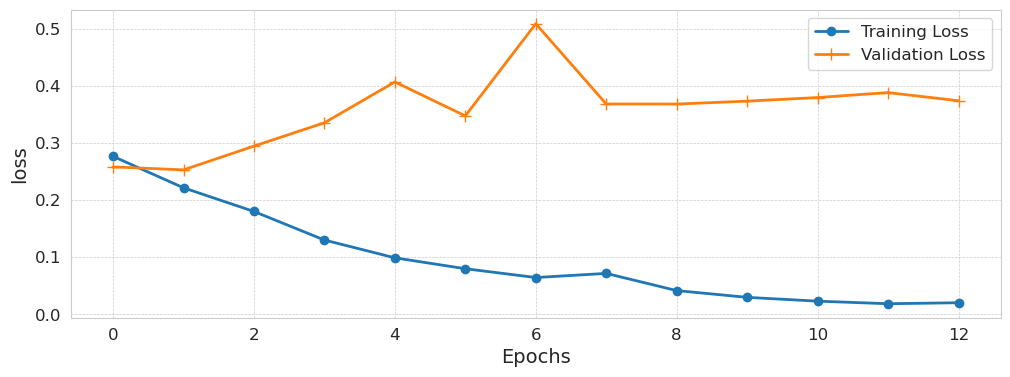

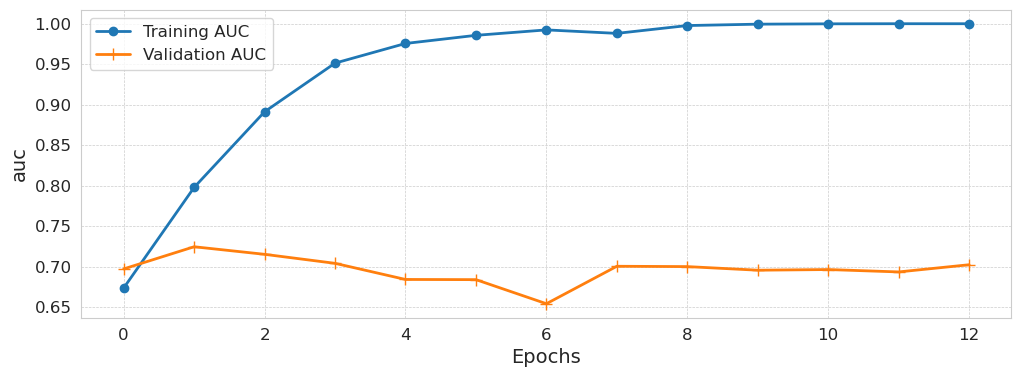

In [18]:
plot_loss_metrics(history, "loss", "auc", "Loss", "AUC")

На графиках видно очевидное переобучение.

87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 106ms/step
AUC для каждого класса
Atelectasis
0 0.7470621950074317
----------------------------------------------
Cardiomegaly
1 0.914759672824189
----------------------------------------------
Consolidation
2 0.663274263904035
----------------------------------------------
Edema
3 0.874014722167937
----------------------------------------------
Effusion
4 0.8271387927441421
----------------------------------------------
Emphysema
5 0.7636804021499017
----------------------------------------------
Fibrosis
6 0.6212976076948584
----------------------------------------------
Hernia
7 0.7708941605839416
----------------------------------------------
Infiltration
8 0.6517694007416475
----------------------------------------------
Nodule/Mass
9 0.6984610286910807
----------------------------------------------
Pleural_Thickening
10 0.617829856803883
----------------------------------------------
Pneumonia
11 0.5248111263736264
----------------------------------

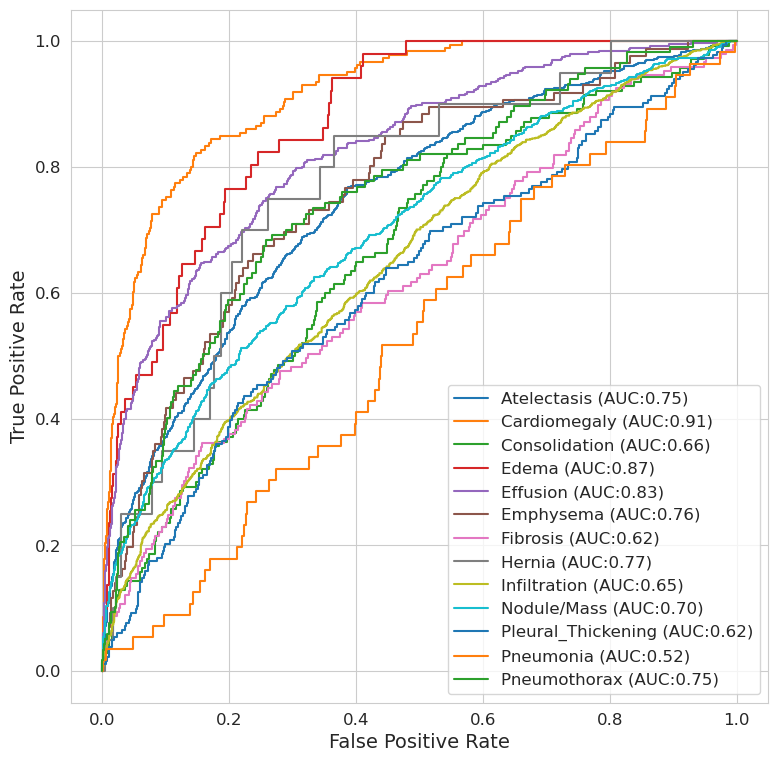

In [19]:
plot_roc_auc(name, dvalid, valid_labels, metadata)

# Предсказание модели на аугментированных данных

In [20]:
name = 'NIH-Augment_model.keras'

decoder = build_decoder(with_labels=True, target_size=(IMG_SIZE, IMG_SIZE))
dtrain = build_dataset(train_paths, train_labels, batch_size=BATCH_SIZE, decode_fn=decoder, augment=True, repeat=True)
dvalid = build_dataset(valid_paths, valid_labels, batch_size=BATCH_SIZE, decode_fn=decoder, augment=False, repeat=False)

2024-08-27 17:41:29.321191: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-08-27 17:41:29.526601: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


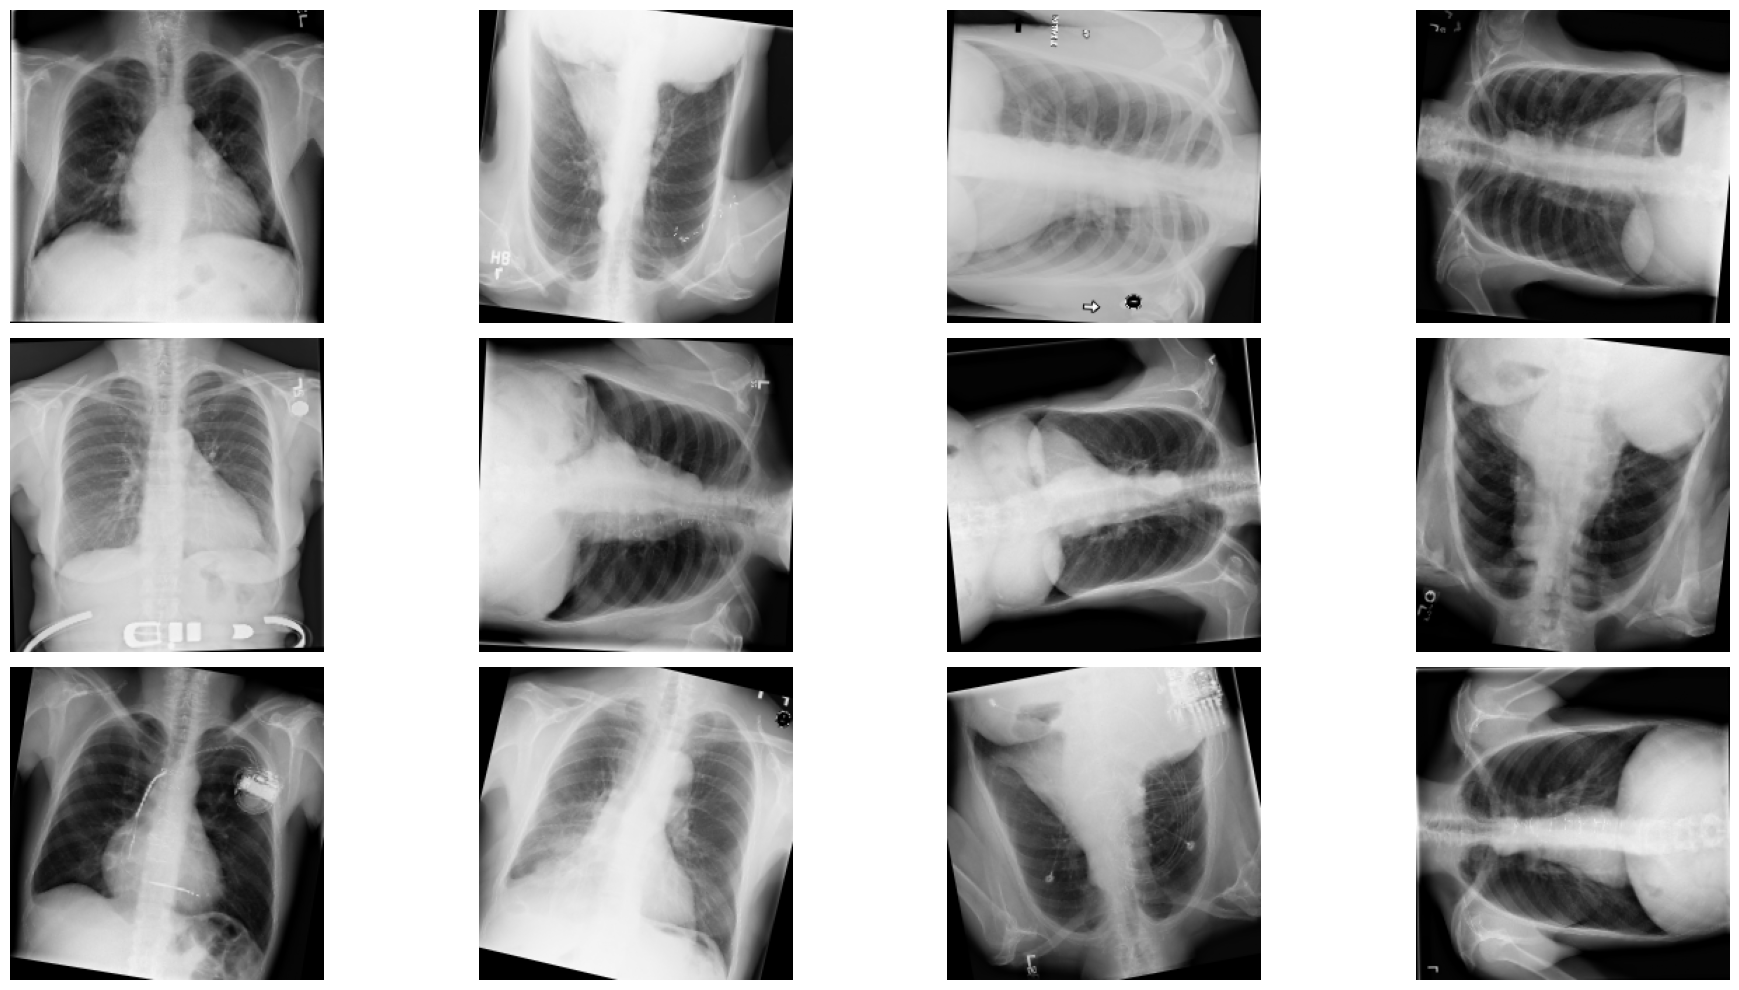

In [21]:
data, _ = dtrain.take(2)
images = data[0].numpy()
fig, axes = plt.subplots(3, 4, figsize=(20,10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [22]:
def build_model():
    base_model = DenseNet121(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
    
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(13, activation='sigmoid')(x)
    
    return Model(inputs=base_model.input, outputs=x)

model = build_model()
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.0)
model.compile(tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),loss=loss,metrics=[tf.keras.metrics.AUC(multi_label=True)])

In [23]:
rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5, verbose = 1, min_delta = 1e-4, min_lr = 1e-7, mode = 'min', cooldown=1)
ckp = ModelCheckpoint(name, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')
es = EarlyStopping(monitor = 'val_loss', min_delta = 1e-4, patience = 11, mode = 'min', restore_best_weights = True, verbose = 1)

callbacks_list = [rlr, ckp, es]

In [24]:
history = model.fit(dtrain,                      
                    validation_data=dvalid,                                       
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    steps_per_epoch=train_paths.shape[0]//BATCH_SIZE,
                    verbose=1)

Epoch 1/100


2024-08-27 17:44:00.722796: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - auc: 0.5659 - loss: 0.3964

2024-08-27 17:45:56.916827: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 1: val_loss improved from inf to 0.27993, saving model to NIH-Augment_model.keras
344/344 ━━━━━━━━━━━━━━━━━━━━ 167s 208ms/step - auc: 0.5661 - loss: 0.3961 - val_auc: 0.6242 - val_loss: 0.2799 - learning_rate: 1.0000e-04
Epoch 2/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - auc: 0.6650 - loss: 0.2675

2024-08-27 17:47:09.002129: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 2: val_loss improved from 0.27993 to 0.26219, saving model to NIH-Augment_model.keras
344/344 ━━━━━━━━━━━━━━━━━━━━ 64s 185ms/step - auc: 0.6651 - loss: 0.2675 - val_auc: 0.6846 - val_loss: 0.2622 - learning_rate: 1.0000e-04
Epoch 3/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - auc: 0.7039 - loss: 0.2595

2024-08-27 17:48:11.684203: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 3: val_loss improved from 0.26219 to 0.25609, saving model to NIH-Augment_model.keras
344/344 ━━━━━━━━━━━━━━━━━━━━ 63s 182ms/step - auc: 0.7039 - loss: 0.2595 - val_auc: 0.7118 - val_loss: 0.2561 - learning_rate: 1.0000e-04
Epoch 4/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - auc: 0.7291 - loss: 0.2519

2024-08-27 17:49:14.199862: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 4: val_loss did not improve from 0.25609
344/344 ━━━━━━━━━━━━━━━━━━━━ 62s 180ms/step - auc: 0.7292 - loss: 0.2519 - val_auc: 0.7264 - val_loss: 0.2570 - learning_rate: 1.0000e-04
Epoch 5/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - auc: 0.7497 - loss: 0.2461

2024-08-27 17:50:15.249090: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 5: val_loss improved from 0.25609 to 0.25549, saving model to NIH-Augment_model.keras
344/344 ━━━━━━━━━━━━━━━━━━━━ 63s 183ms/step - auc: 0.7497 - loss: 0.2460 - val_auc: 0.7328 - val_loss: 0.2555 - learning_rate: 1.0000e-04
Epoch 6/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - auc: 0.7647 - loss: 0.2416

2024-08-27 17:51:17.222733: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 6: val_loss did not improve from 0.25549
344/344 ━━━━━━━━━━━━━━━━━━━━ 66s 191ms/step - auc: 0.7648 - loss: 0.2416 - val_auc: 0.7281 - val_loss: 0.2640 - learning_rate: 1.0000e-04
Epoch 7/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - auc: 0.7734 - loss: 0.2364

2024-08-27 17:52:20.754487: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 7: val_loss did not improve from 0.25549
344/344 ━━━━━━━━━━━━━━━━━━━━ 63s 184ms/step - auc: 0.7735 - loss: 0.2364 - val_auc: 0.7300 - val_loss: 0.2571 - learning_rate: 1.0000e-04
Epoch 8/100
323/344 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - auc: 0.7865 - loss: 0.2334

2024-08-27 17:53:18.293170: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - auc: 0.7875 - loss: 0.2327
Epoch 8: val_loss improved from 0.25549 to 0.25433, saving model to NIH-Augment_model.keras
344/344 ━━━━━━━━━━━━━━━━━━━━ 59s 172ms/step - auc: 0.7875 - loss: 0.2327 - val_auc: 0.7351 - val_loss: 0.2543 - learning_rate: 1.0000e-04
Epoch 9/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - auc: 0.7966 - loss: 0.2279

2024-08-27 17:54:21.377309: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 9: val_loss did not improve from 0.25433
344/344 ━━━━━━━━━━━━━━━━━━━━ 62s 180ms/step - auc: 0.7966 - loss: 0.2278 - val_auc: 0.7432 - val_loss: 0.2624 - learning_rate: 1.0000e-04
Epoch 10/100
335/344 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - auc: 0.8126 - loss: 0.2233

2024-08-27 17:55:21.112840: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - auc: 0.8129 - loss: 0.2231
Epoch 10: val_loss did not improve from 0.25433
344/344 ━━━━━━━━━━━━━━━━━━━━ 62s 179ms/step - auc: 0.8130 - loss: 0.2230 - val_auc: 0.7228 - val_loss: 0.2590 - learning_rate: 1.0000e-04
Epoch 11/100
308/344 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - auc: 0.8243 - loss: 0.2206

2024-08-27 17:56:18.718237: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - auc: 0.8255 - loss: 0.2196
Epoch 11: val_loss did not improve from 0.25433
344/344 ━━━━━━━━━━━━━━━━━━━━ 62s 179ms/step - auc: 0.8256 - loss: 0.2195 - val_auc: 0.7117 - val_loss: 0.2611 - learning_rate: 1.0000e-04
Epoch 12/100
303/344 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - auc: 0.8354 - loss: 0.2149

2024-08-27 17:57:21.207950: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - auc: 0.8363 - loss: 0.2140
Epoch 12: val_loss did not improve from 0.25433
344/344 ━━━━━━━━━━━━━━━━━━━━ 63s 184ms/step - auc: 0.8364 - loss: 0.2140 - val_auc: 0.7407 - val_loss: 0.2586 - learning_rate: 1.0000e-04
Epoch 13/100
310/344 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - auc: 0.8461 - loss: 0.2102

2024-08-27 17:58:24.056163: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - auc: 0.8470 - loss: 0.2094
Epoch 13: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 13: val_loss did not improve from 0.25433
344/344 ━━━━━━━━━━━━━━━━━━━━ 62s 180ms/step - auc: 0.8470 - loss: 0.2094 - val_auc: 0.7120 - val_loss: 0.2704 - learning_rate: 1.0000e-04
Epoch 14/100
313/344 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - auc: 0.8546 - loss: 0.2097

2024-08-27 17:59:25.879896: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - auc: 0.8558 - loss: 0.2086
Epoch 14: val_loss improved from 0.25433 to 0.24670, saving model to NIH-Augment_model.keras
344/344 ━━━━━━━━━━━━━━━━━━━━ 59s 170ms/step - auc: 0.8558 - loss: 0.2086 - val_auc: 0.7533 - val_loss: 0.2467 - learning_rate: 1.0000e-05
Epoch 15/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - auc: 0.8676 - loss: 0.1991

2024-08-27 18:00:31.041073: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 15: val_loss improved from 0.24670 to 0.24545, saving model to NIH-Augment_model.keras
344/344 ━━━━━━━━━━━━━━━━━━━━ 64s 187ms/step - auc: 0.8676 - loss: 0.1991 - val_auc: 0.7534 - val_loss: 0.2454 - learning_rate: 1.0000e-05
Epoch 16/100
316/344 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - auc: 0.8814 - loss: 0.1939

2024-08-27 18:01:30.609734: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - auc: 0.8819 - loss: 0.1933
Epoch 16: val_loss improved from 0.24545 to 0.24471, saving model to NIH-Augment_model.keras
344/344 ━━━━━━━━━━━━━━━━━━━━ 64s 187ms/step - auc: 0.8819 - loss: 0.1933 - val_auc: 0.7527 - val_loss: 0.2447 - learning_rate: 1.0000e-05
Epoch 17/100
311/344 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - auc: 0.8837 - loss: 0.1920

2024-08-27 18:02:36.251836: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - auc: 0.8844 - loss: 0.1913
Epoch 17: val_loss did not improve from 0.24471
344/344 ━━━━━━━━━━━━━━━━━━━━ 66s 191ms/step - auc: 0.8844 - loss: 0.1913 - val_auc: 0.7505 - val_loss: 0.2465 - learning_rate: 1.0000e-05
Epoch 18/100
307/344 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - auc: 0.8876 - loss: 0.1906

2024-08-27 18:03:39.486451: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - auc: 0.8882 - loss: 0.1900
Epoch 18: val_loss did not improve from 0.24471
344/344 ━━━━━━━━━━━━━━━━━━━━ 63s 184ms/step - auc: 0.8883 - loss: 0.1899 - val_auc: 0.7475 - val_loss: 0.2483 - learning_rate: 1.0000e-05
Epoch 19/100
310/344 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - auc: 0.8938 - loss: 0.1869

2024-08-27 18:04:44.582804: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - auc: 0.8942 - loss: 0.1864
Epoch 19: val_loss did not improve from 0.24471
344/344 ━━━━━━━━━━━━━━━━━━━━ 64s 187ms/step - auc: 0.8942 - loss: 0.1864 - val_auc: 0.7484 - val_loss: 0.2481 - learning_rate: 1.0000e-05
Epoch 20/100
307/344 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - auc: 0.8945 - loss: 0.1868

2024-08-27 18:05:48.431313: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - auc: 0.8952 - loss: 0.1862
Epoch 20: val_loss did not improve from 0.24471
344/344 ━━━━━━━━━━━━━━━━━━━━ 64s 187ms/step - auc: 0.8952 - loss: 0.1862 - val_auc: 0.7449 - val_loss: 0.2507 - learning_rate: 1.0000e-05
Epoch 21/100
311/344 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - auc: 0.8998 - loss: 0.1847

2024-08-27 18:06:51.319603: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - auc: 0.9002 - loss: 0.1841
Epoch 21: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 21: val_loss did not improve from 0.24471
344/344 ━━━━━━━━━━━━━━━━━━━━ 58s 170ms/step - auc: 0.9003 - loss: 0.1841 - val_auc: 0.7468 - val_loss: 0.2498 - learning_rate: 1.0000e-05
Epoch 22/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - auc: 0.9019 - loss: 0.1839

2024-08-27 18:07:58.252914: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 22: val_loss did not improve from 0.24471
344/344 ━━━━━━━━━━━━━━━━━━━━ 59s 171ms/step - auc: 0.9019 - loss: 0.1838 - val_auc: 0.7508 - val_loss: 0.2472 - learning_rate: 1.0000e-06
Epoch 23/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - auc: 0.9016 - loss: 0.1824

2024-08-27 18:09:02.139281: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 23: val_loss did not improve from 0.24471
344/344 ━━━━━━━━━━━━━━━━━━━━ 64s 186ms/step - auc: 0.9016 - loss: 0.1824 - val_auc: 0.7511 - val_loss: 0.2468 - learning_rate: 1.0000e-06
Epoch 24/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - auc: 0.9045 - loss: 0.1806

2024-08-27 18:10:05.915885: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 24: val_loss did not improve from 0.24471
344/344 ━━━━━━━━━━━━━━━━━━━━ 63s 183ms/step - auc: 0.9045 - loss: 0.1805 - val_auc: 0.7511 - val_loss: 0.2470 - learning_rate: 1.0000e-06
Epoch 25/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - auc: 0.8996 - loss: 0.1803

2024-08-27 18:11:10.476121: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 25: val_loss did not improve from 0.24471
344/344 ━━━━━━━━━━━━━━━━━━━━ 68s 196ms/step - auc: 0.8996 - loss: 0.1803 - val_auc: 0.7509 - val_loss: 0.2468 - learning_rate: 1.0000e-06
Epoch 26/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - auc: 0.9056 - loss: 0.1802

2024-08-27 18:12:13.218130: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 26: ReduceLROnPlateau reducing learning rate to 1e-07.

Epoch 26: val_loss did not improve from 0.24471
344/344 ━━━━━━━━━━━━━━━━━━━━ 60s 175ms/step - auc: 0.9056 - loss: 0.1802 - val_auc: 0.7514 - val_loss: 0.2468 - learning_rate: 1.0000e-06
Epoch 27/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - auc: 0.9045 - loss: 0.1794

2024-08-27 18:13:17.005716: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 27: val_loss did not improve from 0.24471
344/344 ━━━━━━━━━━━━━━━━━━━━ 63s 182ms/step - auc: 0.9045 - loss: 0.1793 - val_auc: 0.7517 - val_loss: 0.2469 - learning_rate: 1.0000e-07
Epoch 27: early stopping
Restoring model weights from the end of the best epoch: 16.


2024-08-27 18:13:19.503190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{function_node cond_true_182778}}{{node cond/random_rotation_1_1/stateful_uniform/RngReadAndSkip}}]] [type.googleapis.com/tensorflow.DerivedStatus='']
2024-08-27 18:13:19.503463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{function_node cond_true_182778}}{{node cond/random_rotation_1_1/stateful_uniform/RngReadAndSkip}}]]
	 [[cond/pivot_t/_4/_19]] [type.googleapis.com/tensorflow.DerivedStatus='']
2024-08-27 18:13:19.503485: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1682605594171462525
2024-08-27 18:13:19.503498: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14111651280711049205
2024-08-27 18:13:19.503513: I tensorflow/core/f

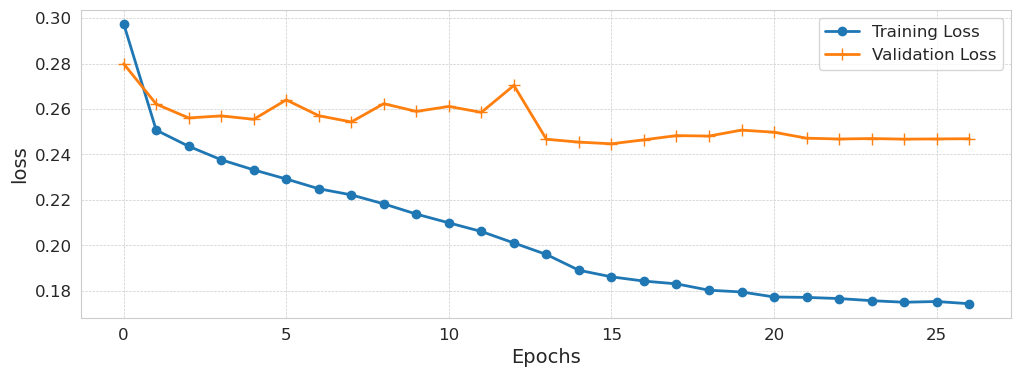

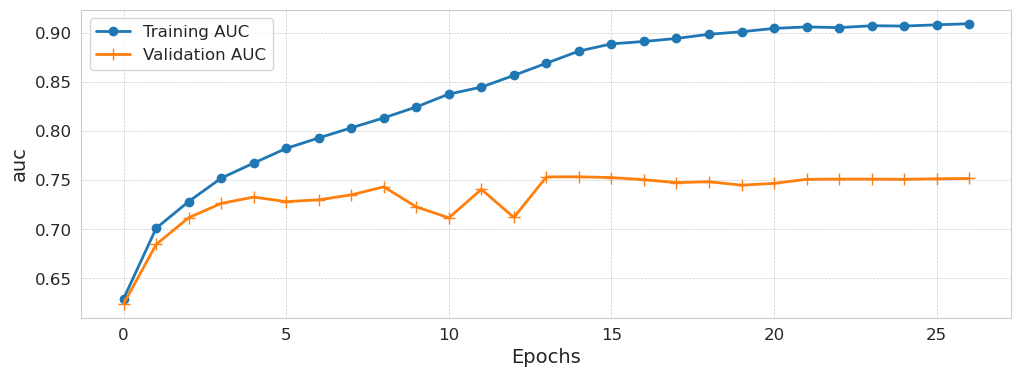

In [25]:
plot_loss_metrics(history, "loss", "auc", "Loss", "AUC")

87/87 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step
AUC для каждого класса
Atelectasis
0 0.7349053976601181
----------------------------------------------
Cardiomegaly
1 0.9079086982312788
----------------------------------------------
Consolidation
2 0.6362895310796074
----------------------------------------------
Edema
3 0.897386344718766
----------------------------------------------
Effusion
4 0.8340025860479198
----------------------------------------------
Emphysema
5 0.7721034596719487
----------------------------------------------
Fibrosis
6 0.7072684229601659
----------------------------------------------
Hernia
7 0.8368613138686132
----------------------------------------------
Infiltration
8 0.698891354046659
----------------------------------------------
Nodule/Mass
9 0.7328957553684399
----------------------------------------------
Pleural_Thickening
10 0.6619358723979042
----------------------------------------------
Pneumonia
11 0.6095202874049028
---------------------------------

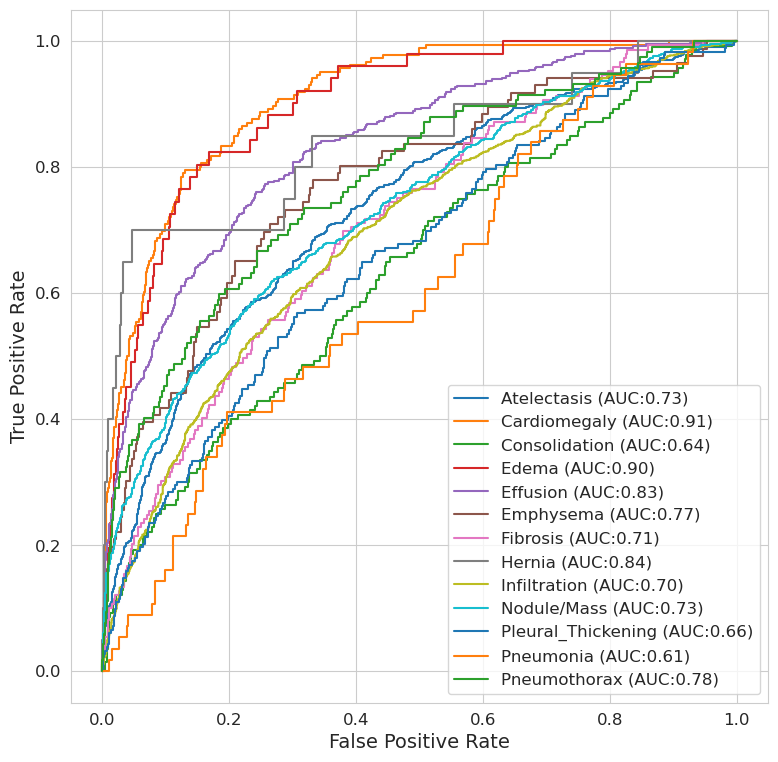

In [26]:
plot_roc_auc(name, dvalid, valid_labels, metadata)

Результат заметно улучшился.

# Предсказание модели со слоем внимания

In [27]:
name = 'NIH-Attention_model.keras'

decoder = build_decoder(with_labels=True, target_size=(IMG_SIZE, IMG_SIZE))
dtrain = build_dataset(train_paths, train_labels, batch_size=BATCH_SIZE, decode_fn=decoder, augment=True, repeat=True)
dvalid = build_dataset(valid_paths, valid_labels, batch_size=BATCH_SIZE, decode_fn=decoder, augment=False, repeat=False)

2024-08-27 18:18:57.781251: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-08-27 18:18:57.973411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


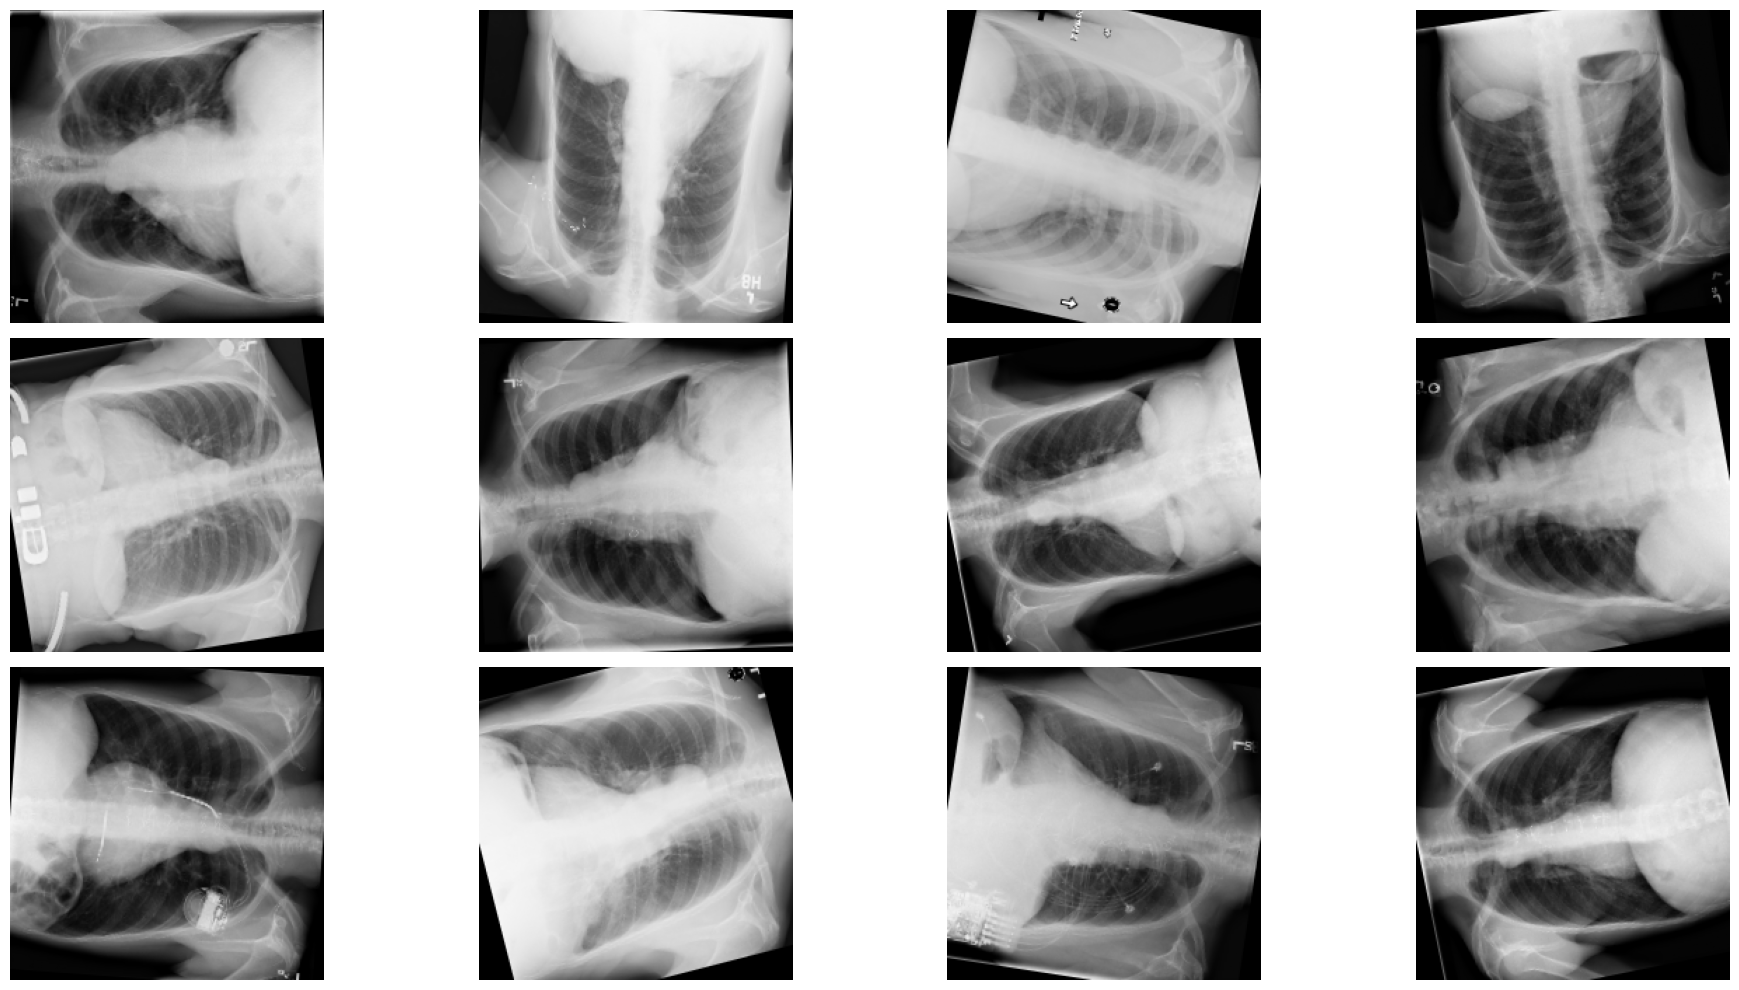

In [28]:
data, _ = dtrain.take(2)
images = data[0].numpy()
fig, axes = plt.subplots(3, 4, figsize=(20,10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [29]:
def build_model():
    base_model = DenseNet121(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)

    attention = layers.Dense(1024, activation='relu')(x)
    attention = layers.Dense(1024, activation='sigmoid')(attention)
    x = Multiply()([x, attention])

    x = layers.Dense(13, activation='sigmoid')(x)

    return Model(inputs=base_model.input, outputs=x)

model = build_model()
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.0)
model.compile(tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),loss=loss,metrics=[tf.keras.metrics.AUC(multi_label=True)])

In [30]:
rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5, verbose = 1, min_delta = 1e-4, min_lr = 1e-7, mode = 'min', cooldown=1)
ckp = ModelCheckpoint(name, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')
es = EarlyStopping(monitor = 'val_loss', min_delta = 1e-4, patience = 11, mode = 'min', restore_best_weights = True, verbose = 1)

callbacks_list = [rlr, ckp, es]

In [31]:
history = model.fit(dtrain,                      
                    validation_data=dvalid,                                       
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    steps_per_epoch=train_paths.shape[0]//BATCH_SIZE,
                    verbose=1)

Epoch 1/100


2024-08-27 18:19:54.749141: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
I0000 00:00:1724757605.558102   11007 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_30829', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1724757605.692701   11011 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_32667', 40 bytes spill stores, 40 bytes spill loads

I0000 00:00:1724757605.789102   11012 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_30836', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1724757605.802434   11009 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_32667', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1724757605.922323   11003 asm_compiler.cc:369]

344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - auc: 0.5828 - loss: 0.3289

2024-08-27 18:21:57.110158: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
I0000 00:00:1724757729.881566   11183 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3302', 4 bytes spill stores, 4 bytes spill loads




Epoch 1: val_loss improved from inf to 0.27381, saving model to NIH-Attention_model.keras
344/344 ━━━━━━━━━━━━━━━━━━━━ 179s 229ms/step - auc: 0.5830 - loss: 0.3288 - val_auc: 0.6357 - val_loss: 0.2738 - learning_rate: 1.0000e-04
Epoch 2/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - auc: 0.6695 - loss: 0.2674

2024-08-27 18:23:16.004398: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 2: val_loss improved from 0.27381 to 0.26175, saving model to NIH-Attention_model.keras
344/344 ━━━━━━━━━━━━━━━━━━━━ 66s 192ms/step - auc: 0.6696 - loss: 0.2673 - val_auc: 0.7044 - val_loss: 0.2617 - learning_rate: 1.0000e-04
Epoch 3/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - auc: 0.7068 - loss: 0.2586

2024-08-27 18:24:22.362673: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 3: val_loss improved from 0.26175 to 0.25712, saving model to NIH-Attention_model.keras
344/344 ━━━━━━━━━━━━━━━━━━━━ 67s 194ms/step - auc: 0.7069 - loss: 0.2585 - val_auc: 0.7085 - val_loss: 0.2571 - learning_rate: 1.0000e-04
Epoch 4/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - auc: 0.7330 - loss: 0.2507

2024-08-27 18:25:28.890047: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 4: val_loss improved from 0.25712 to 0.25414, saving model to NIH-Attention_model.keras
344/344 ━━━━━━━━━━━━━━━━━━━━ 67s 194ms/step - auc: 0.7331 - loss: 0.2507 - val_auc: 0.7154 - val_loss: 0.2541 - learning_rate: 1.0000e-04
Epoch 5/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - auc: 0.7561 - loss: 0.2447

2024-08-27 18:26:34.634857: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 5: val_loss improved from 0.25414 to 0.24656, saving model to NIH-Attention_model.keras
344/344 ━━━━━━━━━━━━━━━━━━━━ 68s 198ms/step - auc: 0.7562 - loss: 0.2447 - val_auc: 0.7345 - val_loss: 0.2466 - learning_rate: 1.0000e-04
Epoch 6/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - auc: 0.7658 - loss: 0.2404

2024-08-27 18:27:41.548325: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 6: val_loss did not improve from 0.24656
344/344 ━━━━━━━━━━━━━━━━━━━━ 68s 199ms/step - auc: 0.7659 - loss: 0.2404 - val_auc: 0.7364 - val_loss: 0.2467 - learning_rate: 1.0000e-04
Epoch 7/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - auc: 0.7794 - loss: 0.2352

2024-08-27 18:28:47.661067: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 7: val_loss did not improve from 0.24656
344/344 ━━━━━━━━━━━━━━━━━━━━ 66s 191ms/step - auc: 0.7795 - loss: 0.2351 - val_auc: 0.7226 - val_loss: 0.2574 - learning_rate: 1.0000e-04
Epoch 8/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - auc: 0.7917 - loss: 0.2301

2024-08-27 18:29:50.298872: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 8: val_loss did not improve from 0.24656
344/344 ━━━━━━━━━━━━━━━━━━━━ 63s 184ms/step - auc: 0.7917 - loss: 0.2300 - val_auc: 0.7311 - val_loss: 0.2540 - learning_rate: 1.0000e-04
Epoch 9/100
305/344 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - auc: 0.7986 - loss: 0.2270

2024-08-27 18:30:47.474141: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - auc: 0.8006 - loss: 0.2259
Epoch 9: val_loss did not improve from 0.24656
344/344 ━━━━━━━━━━━━━━━━━━━━ 64s 186ms/step - auc: 0.8007 - loss: 0.2258 - val_auc: 0.7360 - val_loss: 0.2545 - learning_rate: 1.0000e-04
Epoch 10/100
288/344 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - auc: 0.8140 - loss: 0.2226

2024-08-27 18:31:51.426574: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - auc: 0.8164 - loss: 0.2212
Epoch 10: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 10: val_loss did not improve from 0.24656
344/344 ━━━━━━━━━━━━━━━━━━━━ 63s 184ms/step - auc: 0.8165 - loss: 0.2211 - val_auc: 0.7325 - val_loss: 0.2570 - learning_rate: 1.0000e-04
Epoch 11/100
343/344 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - auc: 0.8286 - loss: 0.2220

2024-08-27 18:33:01.676256: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - auc: 0.8287 - loss: 0.2220
Epoch 11: val_loss improved from 0.24656 to 0.24158, saving model to NIH-Attention_model.keras
344/344 ━━━━━━━━━━━━━━━━━━━━ 65s 189ms/step - auc: 0.8287 - loss: 0.2220 - val_auc: 0.7589 - val_loss: 0.2416 - learning_rate: 1.0000e-05
Epoch 12/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - auc: 0.8477 - loss: 0.2116

2024-08-27 18:34:07.815186: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 12: val_loss improved from 0.24158 to 0.24031, saving model to NIH-Attention_model.keras
344/344 ━━━━━━━━━━━━━━━━━━━━ 66s 193ms/step - auc: 0.8477 - loss: 0.2116 - val_auc: 0.7656 - val_loss: 0.2403 - learning_rate: 1.0000e-05
Epoch 13/100
293/344 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - auc: 0.8463 - loss: 0.2093

2024-08-27 18:35:04.683983: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - auc: 0.8483 - loss: 0.2082
Epoch 13: val_loss improved from 0.24031 to 0.23937, saving model to NIH-Attention_model.keras
344/344 ━━━━━━━━━━━━━━━━━━━━ 65s 190ms/step - auc: 0.8483 - loss: 0.2081 - val_auc: 0.7625 - val_loss: 0.2394 - learning_rate: 1.0000e-05
Epoch 14/100
292/344 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - auc: 0.8560 - loss: 0.2062

2024-08-27 18:36:10.427120: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - auc: 0.8576 - loss: 0.2051
Epoch 14: val_loss did not improve from 0.23937
344/344 ━━━━━━━━━━━━━━━━━━━━ 65s 189ms/step - auc: 0.8576 - loss: 0.2051 - val_auc: 0.7633 - val_loss: 0.2398 - learning_rate: 1.0000e-05
Epoch 15/100
292/344 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - auc: 0.8564 - loss: 0.2044

2024-08-27 18:37:15.257251: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - auc: 0.8582 - loss: 0.2034
Epoch 15: val_loss did not improve from 0.23937
344/344 ━━━━━━━━━━━━━━━━━━━━ 61s 178ms/step - auc: 0.8582 - loss: 0.2034 - val_auc: 0.7605 - val_loss: 0.2409 - learning_rate: 1.0000e-05
Epoch 16/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - auc: 0.8656 - loss: 0.2026

2024-08-27 18:38:23.096273: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 16: val_loss did not improve from 0.23937
344/344 ━━━━━━━━━━━━━━━━━━━━ 58s 169ms/step - auc: 0.8656 - loss: 0.2026 - val_auc: 0.7608 - val_loss: 0.2404 - learning_rate: 1.0000e-05
Epoch 17/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - auc: 0.8673 - loss: 0.2003

2024-08-27 18:39:26.589204: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 17: val_loss did not improve from 0.23937
344/344 ━━━━━━━━━━━━━━━━━━━━ 66s 192ms/step - auc: 0.8673 - loss: 0.2003 - val_auc: 0.7629 - val_loss: 0.2417 - learning_rate: 1.0000e-05
Epoch 18/100
336/344 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - auc: 0.8709 - loss: 0.1986

2024-08-27 18:40:27.439650: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - auc: 0.8711 - loss: 0.1984
Epoch 18: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 18: val_loss did not improve from 0.23937
344/344 ━━━━━━━━━━━━━━━━━━━━ 65s 188ms/step - auc: 0.8711 - loss: 0.1984 - val_auc: 0.7616 - val_loss: 0.2428 - learning_rate: 1.0000e-05
Epoch 19/100
325/344 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - auc: 0.8765 - loss: 0.1985

2024-08-27 18:41:30.591690: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - auc: 0.8768 - loss: 0.1981
Epoch 19: val_loss did not improve from 0.23937
344/344 ━━━━━━━━━━━━━━━━━━━━ 65s 189ms/step - auc: 0.8768 - loss: 0.1981 - val_auc: 0.7629 - val_loss: 0.2407 - learning_rate: 1.0000e-06
Epoch 20/100
312/344 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - auc: 0.8746 - loss: 0.1985

2024-08-27 18:42:34.433531: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - auc: 0.8752 - loss: 0.1979
Epoch 20: val_loss did not improve from 0.23937
344/344 ━━━━━━━━━━━━━━━━━━━━ 66s 191ms/step - auc: 0.8752 - loss: 0.1979 - val_auc: 0.7646 - val_loss: 0.2405 - learning_rate: 1.0000e-06
Epoch 21/100
319/344 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - auc: 0.8777 - loss: 0.1977

2024-08-27 18:43:39.497486: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - auc: 0.8780 - loss: 0.1972
Epoch 21: val_loss did not improve from 0.23937
344/344 ━━━━━━━━━━━━━━━━━━━━ 61s 177ms/step - auc: 0.8780 - loss: 0.1972 - val_auc: 0.7638 - val_loss: 0.2406 - learning_rate: 1.0000e-06
Epoch 22/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - auc: 0.8777 - loss: 0.1955

2024-08-27 18:44:48.399624: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 22: val_loss did not improve from 0.23937
344/344 ━━━━━━━━━━━━━━━━━━━━ 61s 178ms/step - auc: 0.8777 - loss: 0.1954 - val_auc: 0.7645 - val_loss: 0.2405 - learning_rate: 1.0000e-06
Epoch 23/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - auc: 0.8792 - loss: 0.1953

2024-08-27 18:45:52.684394: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 23: ReduceLROnPlateau reducing learning rate to 1e-07.

Epoch 23: val_loss did not improve from 0.23937
344/344 ━━━━━━━━━━━━━━━━━━━━ 63s 184ms/step - auc: 0.8792 - loss: 0.1953 - val_auc: 0.7646 - val_loss: 0.2405 - learning_rate: 1.0000e-06
Epoch 24/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - auc: 0.8791 - loss: 0.1941

2024-08-27 18:46:55.531931: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 24: val_loss did not improve from 0.23937
344/344 ━━━━━━━━━━━━━━━━━━━━ 63s 183ms/step - auc: 0.8791 - loss: 0.1941 - val_auc: 0.7641 - val_loss: 0.2407 - learning_rate: 1.0000e-07
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 13.


2024-08-27 18:46:58.589608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{function_node cond_true_460765}}{{node cond/random_rotation_1_1/stateful_uniform/Cast_1}}]] [type.googleapis.com/tensorflow.DerivedStatus='']
2024-08-27 18:46:58.590068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{function_node cond_true_460765}}{{node cond/random_rotation_1_1/stateful_uniform/Cast_1}}]]
	 [[cond/then/_0/cond/random_rotation_1_1/stateful_uniform/Cast_1/_21]] [type.googleapis.com/tensorflow.DerivedStatus='']
2024-08-27 18:46:58.590101: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14111651280711049205
2024-08-27 18:46:58.590158: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3951001357521040062
2024-08-27 18:46:

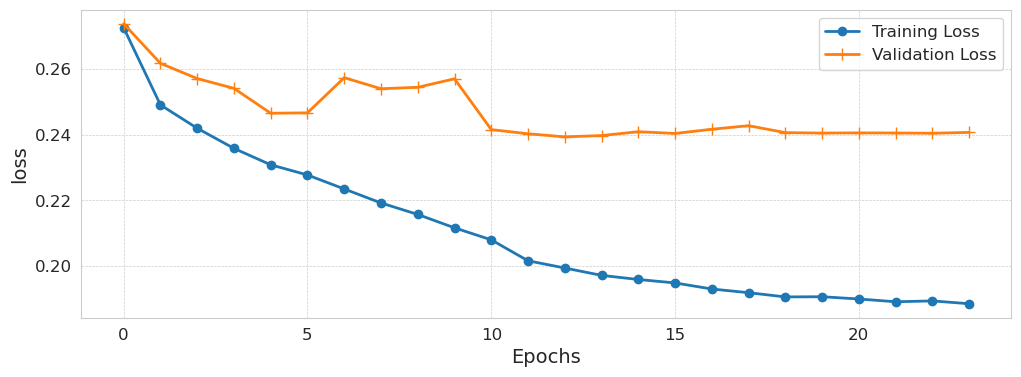

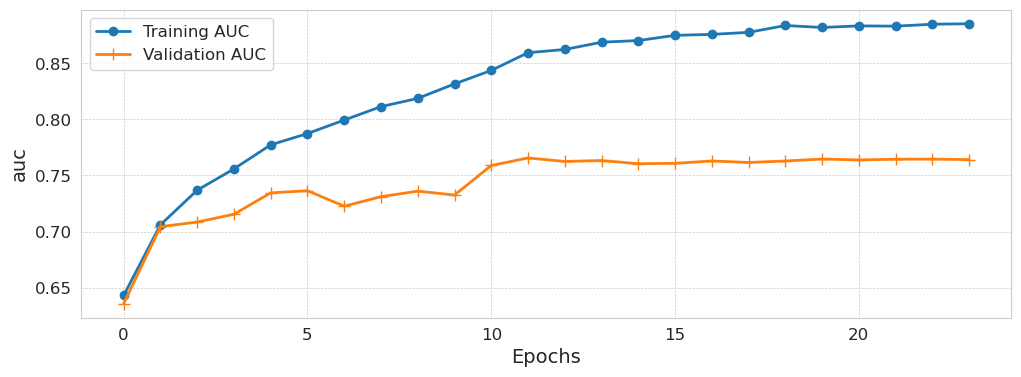

In [32]:
plot_loss_metrics(history, "loss", "auc", "Loss", "AUC")

87/87 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step
AUC для каждого класса
Atelectasis
0 0.7403179532347427
----------------------------------------------
Cardiomegaly
1 0.9050283647057841
----------------------------------------------
Consolidation
2 0.6853271537622684
----------------------------------------------
Edema
3 0.9085401602501465
----------------------------------------------
Effusion
4 0.8473741380284423
----------------------------------------------
Emphysema
5 0.7825137847663112
----------------------------------------------
Fibrosis
6 0.7200949005112598
----------------------------------------------
Hernia
7 0.8485948905109488
----------------------------------------------
Infiltration
8 0.6992440641201036
----------------------------------------------
Nodule/Mass
9 0.7320019435534171
----------------------------------------------
Pleural_Thickening
10 0.6675869556458881
----------------------------------------------
Pneumonia
11 0.6375475486052409
------------------------------

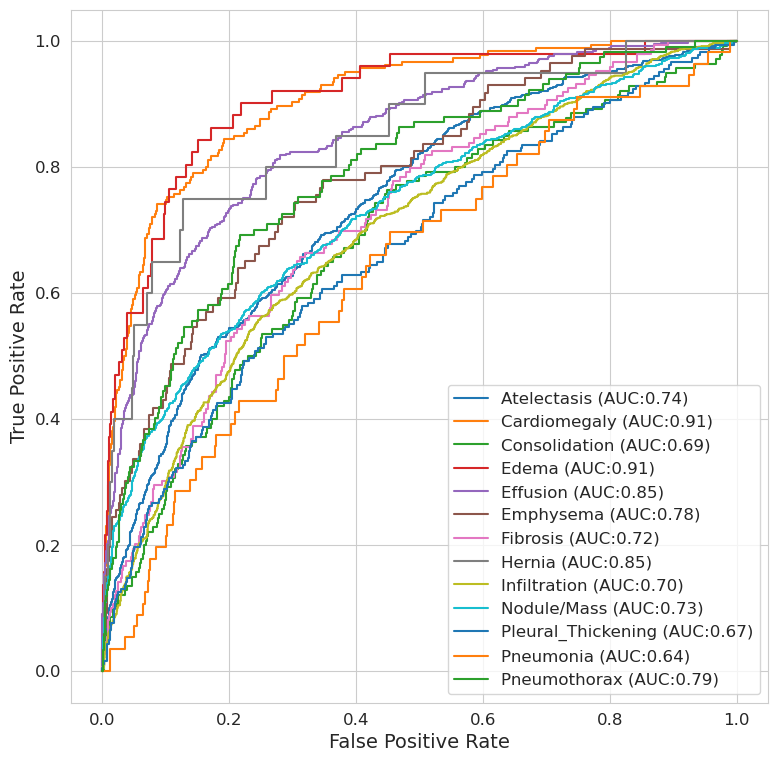

In [33]:
plot_roc_auc(name, dvalid, valid_labels, metadata)

Для нашей патологии результат практически не изменился, но для других патологий ROC-AUC вырос.

# Выводы

После анализа результатов, полученных с использованием нашего подхода, мы пришли к выводу, что, несмотря на исправление ошибок предыдущих исследований, улучшение результатов не было столь значительным, как ожидалось. Это наблюдение подтолкнуло нас к дальнейшему изучению влияния качества размеченных данных на конечный результат. Мы предполагаем, что даже мелкие неточности в данных могут существенно сказаться на эффективности и точности моделей.